In [25]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
import os
import sys
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

### Building the model architecture

In [27]:
class ConvBlock(nn.Module):
    def __init__(self, m, in_filters, out_filters, kernel_size=3, batchnorm=True, last_activ=F.relu):
        super(ConvBlock, self).__init__()
        if m==50:
            self.bn = batchnorm
            self.last_activ = last_activ
            self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
            self.b1 = nn.BatchNorm2d(out_filters)
            self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
            self.b2 = nn.BatchNorm2d(out_filters)
        else:
            self.bn = batchnorm
            self.last_activ = last_activ
            self.encoder = torchvision.models.vgg16(pretrained=True).features
            #self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
            self.c1 = self.encoder[m]
            self.b1 = nn.BatchNorm2d(out_filters)
            #self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
            self.c2 = self.encoder[m+2]
            self.b2 = nn.BatchNorm2d(out_filters)
    def forward(self, x):
        x = self.c1(x)
        if self.bn: x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn: x = self.b2(x)
        x = self.last_activ(x)
        return x

In [28]:
class ContractiveBlock(nn.Module):
    def __init__(self, m, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5,  batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvBlock(m=m, in_filters=in_filters, out_filters=out_filters,  kernel_size=conv_kern, batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern, ceil_mode=True)
        self.d1 = nn.Dropout2d(dropout)
    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))

In [29]:
class ExpansiveBlock(nn.Module):
    def __init__(self,in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvBlock(50,out_filters+in_filters2, out_filters, conv_kern,dilation)
        
    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin

In [30]:
class Unet(nn.Module):
    def __init__(self, n_labels, n_filters=64, p_dropout=0.5, dilation=2, batchnorm=True):
        super(Unet, self).__init__()
        filter_dict = {}
        filt_pair = [3, n_filters]
        m=[0,5,10,17,24]
        for i in range(4):
            self.add_module('contractive_'+str(i), ContractiveBlock(m[i], filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filter_dict['contractive_'+str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2
        
        self.bottleneck = ConvBlock(50,filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filter_dict['bottleneck'] = (filt_pair[0], filt_pair[1])
        
        for i in reversed(range(4)):
            self.add_module('expansive_'+str(i), ExpansiveBlock(filt_pair[1], filter_dict['contractive_'+str(i)][1],  filt_pair[0]))
            filter_dict['expansive_'+str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2
        
        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filter_dict['output'] = (filt_pair[1], n_labels)
        self.filter_dict = filter_dict
    
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)
        

In [31]:
net = Unet(2).cuda()

In [32]:
print(net)

Unet(
  (contractive_0): ContractiveBlock(
    (c1): ConvBlock(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [33]:
cv=0
for child in net.children():
    cv+=1
    if cv<6:
        for param in child.parameters():
            param.requires_grad = False

In [34]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'total':total_num,'trainable':trainable_num}

In [35]:
get_parameter_number(net)

{'total': 88698562, 'trainable': 15674050}

In [36]:
net_vgg16 = torchvision.models.vgg16(pretrained=True).features
net_vgg16.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, ker

In [37]:
m=[0,5,10,17,24]
for i in range(4):
    print(i)
    print(m[i])

0
0
1
5
2
10
3
17


Dataloader

In [38]:
class TSegLoader(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder):
        self.images = os.listdir(image_folder)
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        
# In practice the model performed better without normalisation, 
# Uncomment the line with Normalization if you wish to work with normalised images

        self.tx = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
        
        self.mx = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x : torch.cat([x,1-x], dim=0))
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        i1 = Image.open(self.image_folder + self.images[i])
        m1 = Image.open(self.mask_folder + self.images[i])
        
        return self.tx(i1), self.mx(m1)

In [39]:
tr = torch.utils.data.DataLoader(TSegLoader('DRIVE2/input_3channel/','DRIVE2/target/'), batch_size=8, shuffle=True)

In [40]:
opt = torch.optim.Adam( filter(lambda p: p.requires_grad, net.parameters()))

### Training 

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
loss_history = []
for i in range(1600):
    train_loss = 0.0
    for x, y in tr:
        x, y = x.cuda(),y.cuda()
        opt.zero_grad()
        y_pred = net(x)
        loss = F.mse_loss(y_pred, y)
        train_loss +=loss.item()
        loss.backward()
        opt.step()   
    print (i,train_loss)
    loss_history.append(train_loss)
plt.plot(loss_history)

0 21.698591731488705
1 18.812820438295603
2 18.45315220952034
3 18.26037695631385
4 18.037658717483282
5 17.888335466384888
6 17.779991261661053
7 17.712428513914347
8 17.644469518214464
9 17.514633510261774
10 17.539002235978842
11 17.44345534220338
12 17.324210200458765
13 17.31948994845152
14 17.207568883895874
15 17.280362643301487


KeyboardInterrupt: 

In [15]:
screen

NameError: name 'screen' is not defined

In [43]:
torch.save(net.state_dict(), 'output_models/torch/unet_vgg16_inunet2.pth')

### Testing phase

In [44]:
net.filter_dict

{'contractive_0': (3, 64),
 'contractive_1': (64, 128),
 'contractive_2': (128, 256),
 'contractive_3': (256, 512),
 'bottleneck': (512, 1024),
 'expansive_3': (1024, 512),
 'expansive_2': (512, 256),
 'expansive_1': (256, 128),
 'expansive_0': (128, 64),
 'output': (64, 2)}

In [45]:
torch.cuda.empty_cache()

In [46]:
# Uncomment the line with Normalize if working with Normalized images during training
data_tranform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])

In [47]:
net.load_state_dict(torch.load('output_models/torch/unet_vgg16_inunet.pth'))
net.eval();

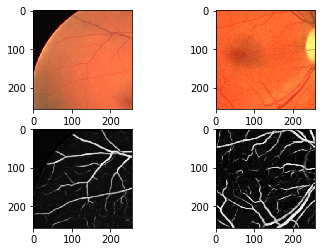

In [49]:
image_id = str(np.random.randint(0,640))
im = Image.open('DRIVE2/input_3channel/' + image_id  + '_orig.jpg')
im_noise = Image.open('DRIVE2/input_3channel/' + image_id  + '_noise.jpg')

s = data_tranform(im).unsqueeze(0)
s = torch.cat((s,data_tranform(im_noise).unsqueeze(0)))

pred= net(s.cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(im)
f.add_subplot(2,2, 2)
plt.imshow(im_noise)
f.add_subplot(2,2, 3)
plt.imshow(pred[0][0],cmap='gray')
f.add_subplot(2,2, 4)
plt.imshow(pred[1][0],cmap='gray')


### Diabetic retinopathy

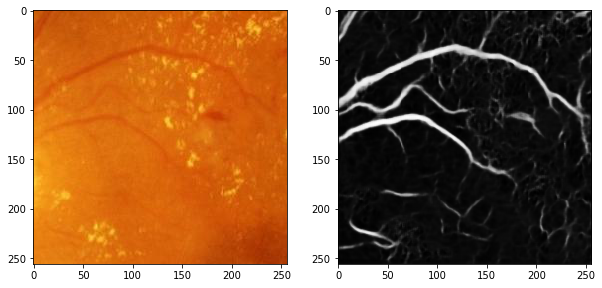

In [0]:
im = Image.open('samples/diabetic-retinopathy-header.jpg')
im = np.asarray(im)
im = im[200:456,400:656]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

### Pigmentosa

In [0]:
im = Image.open('samples/pigmentosa.jpg')
im = np.asarray(im)
im = im[260:516,350:606]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

### Haemorrhage

In [0]:
im = Image.open('samples/haemorrhage1.jpg')
im = np.asarray(im)
im = im[0:256,20:276]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

In [0]:
im = Image.open('samples/haemorrhage2.jpg')
im = np.asarray(im)
im = im[0:256,20:276]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

In [0]:
im = Image.open('samples/haemorrhage3.png').convert('RGB')
im = np.asarray(im)
im = im[100:356,200:456]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')